
<a id='numerical-linear-algebra'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Álgebra Linear Numérica e Fatorizações

## Conteúdo

- [Álgebra Linear Numérica e Fatorizações](#Álgebra-Linear-Numérica-e-Fatorizações)  
  - [Resumo](#Resumo)  
  - [Fatorizações](#Fatorizações)  
  - [Cadeias de Markov em Tempo Contínuo (CMTC)](#Cadeias-de-Markov-em-Tempo-Contínuo-%28CMTC%29)  
  - [Matrizes em Faixas](#Matrizes-em-Faixas)  
  - [Detalhes da Implementação e Performance](#Detalhes-da-Implementação-e-Performance)  
  - [Exercícios](#Exercícios)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://julia.quantecon.org/) pelos bolsistas CNPq Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob a supervisão do Prof. Christiano Penna, do CAEN/UFC.*

> >Você não pode aprender muita álgebra linear. – Benedict Gross

## Resumo

Nesta palestra, examinamos a estrutura de matrizes e operadores lineares (por exemplo, densos, esparsos, simétricos, tridiagonais, em faixas) e discutimos como a estrutura pode ser explorada para aumentar radicalmente o desempenho da solução de grandes problemas.

Desenvolvemos aplicativos discutidos em aulas anteriores: [álgebra linear](https://julia.quantecon.org/linear_algebra.html), [projeções ortogonais](https://julia.quantecon.org/orth_proj.html) e [Cadeias de Markov](https://julia.quantecon.org/finite_markov.html).

Os métodos nesta seção são chamados de métodos diretos e são qualitativamente similares à realização da eliminação gaussiana para fatorar matrizes e resolver sistemas de equações. Em [métodos iterativos e esparsidade](https://julia.quantecon.org/iterative_methods_sparsity.html), examinamos uma abordagem diferente, usando algoritmos iterativos, nos quais podemos pensar em operadores lineares mais gerais.

A lista de pacotes especializados para essas tarefas é enorme e crescente, mas algumas das organizações importantes a
ver são [JuliaMatrices](https://github.com/JuliaMatrices), [JuliaSparse](https://github.com/JuliaSparse) e [JuliaMath](https://github.com/JuliaMath)

* NOTA *: Como esta seção usa técnicas avançadas de Julia, você pode revisar a programação de despacho múltiplo e genérico na introdução aos tipos e considerar um estudo mais aprofundado sobre [programação genérica](https://julia.quantecon.org/../more_julia/generic_programming.html).

O tema desta palestra e a álgebra linear numérica em geral se resume a três princípios:

1. **Identificar a estrutura** (por exemplo, [simétrica, esparsa, diagonal, etc.](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/index.html#Special-matrices-1)) de matrizes para usar **algoritmos especializados**;
2. **Não perca a estrutura** aplicando operações de álgebra linear incorretas nos horários errados (por exemplo, matriz esparsa se tornando densa), e
3. Procure entender a **complexidade computacional** de cada algoritmo, dada a estrutura.

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics, BenchmarkTools, SparseArrays, Random
Random.seed!(42);  # seed random numbers for reproducibility

### Complexidade computacional

Pergunte a si mesmo se o seguinte é uma operação **computacionalmente cara** à medida que o tamanho da matriz **aumenta**

- Multiplicando duas matrizes?
  
  - *Resposta*: Depende. Multiplicar 2 matrizes diagonais é trivial.
  
- Resolvendo um sistema linear de equações?
  
  - *Resposta*: Depende. Se a matriz é a identidade, a solução é o próprio vetor.
  
- Encontrando os autovalores de uma matriz?
  
  - *Resposta*: Depende. Os autovalores de uma matriz triangular são a diagonal.
  


Como o objetivo desta seção é avançar para métodos numéricos com sistemas grandes, precisamos entender quão bem os algoritmos escalam com o tamanho de matrizes / vetores / etc. Isso é conhecido como [complexidade computacional](https://en.wikipedia.org/wiki/Computational_complexity). Como vimos na resposta às perguntas acima, o algoritmo - e, portanto, a complexidade computacional - muda com base na estrutura da matriz.

Embora essa noção de complexidade possa funcionar em vários níveis, como o número de [dígitos significativos](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematics_operations#Arithmetic_functions) para operações matemáticas básicas), a quantidade de memória e armazenamento necessários ou a quantidade de tempo - normalmente focaremos na complexidade do tempo.

Para complexidade do tempo, o tamanho $ N $ geralmente é a dimensionalidade do problema, embora, ocasionalmente, a chave seja o número de não-zeros na matriz ou a largura das bandas. Para nossas aplicações, a complexidade do tempo é considerada como o número de operações de ponto flutuante (por exemplo, adicionar, multiplicar etc.) necessárias.

#### Notação

A complexidade dos algoritmos é tipicamente escrita na notação [Big O](https://en.wikipedia.org/wiki/Big_O_notation) que fornece limites para a escala.

Formalmente, se o número de operações necessárias para um tamanho de problema $ N $ for $ f (N) $, podemos escrever isso como $ f (N) = O (g (N)) $ por alguns $ g (N) $ - tipicamente um polinômio.

A interpretação é que existem algumas constantes $ M $ e $ N_0 $ tais que

$$
f(N) \leq M g(N), \text{ for } N > N_0
$$

Por exemplo, a complexidade de encontrar uma decomposição LU de uma matriz densa é $ O (N ^ 3) $, que deve ser lida como uma constante onde eventualmente, o número de operações de ponto flutuante necessário decompõe uma matriz de tamanho $ N \times N $ cresce cubicamente.

Lembre-se de que esses são resultados assintóticos destinados a entender a escala do problema, e a constante pode ser importante para um dado tamanho fixo.

Por exemplo, o número de operações necessárias para uma [decomposição da LU](https://en.wikipedia.org/wiki/LU_decomposition#Algorithms) de uma matriz densa de $ N \times N $ é $ f (N) = \frac {2} {3} N ^ 3 $, ignorando os $ N ^ 2 $ e os termos inferiores. Outros métodos para resolver um sistema linear podem ter constantes diferentes de proporcionalidade, mesmo que tenham a mesma escala $ O (N ^ 3) $.

### Regras de complexidade computacional

Às vezes, você precisará pensar em como [combinar algoritmos](https://en.wikipedia.org/wiki/Big_O_notation#Properties) altera a complexidade. Por exemplo, se você usar:

1. Uma operação $ O (N ^ 3) $ $ P $ vezes, simplesmente muda a constante. A complexidade permanece $ O (N ^ 3) $
2. Uma operação de $ O (N ^ 3) $ e outra operação de $ O (N ^ 2) $ one, então você leva o máximo. A complexidade permanece $ O (N ^ 3) $
3. Uma repetição de uma operação de $ O (N) $ que usa ela própria um $ O (N) $ um, você pega o produto. A complexidade se torna $ O (N ^ 2) $


Com isso, temos uma palavra importante de cautela: a multiplicação densa de matrizes é uma [operação cara](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra) para matrizes não estruturadas e a versão básica é $ O ( N ^ 3) $.

Obviamente, as bibliotecas modernas usam algoritmos [altamente ajustados e numericamente estáveis](https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm) para multiplicar matrizes e explorar a arquitetura do computador, o cache de memória, etc., mas isso simplesmente reduz a constante proporcionalidade e permanecem $ O (N ^ 3) $.

Uma conseqüência é que, como muitos algoritmos requerem multiplicação matriz-matriz, muitas vezes não é possível ficar abaixo dessa ordem sem mais estrutura matricial.

Ou seja, alterar a constante de proporcionalidade para um determinado tamanho pode ajudar, mas, para alcançar um escalonamento mais alto, é necessário identificar a estrutura da matriz (por exemplo, tridigonal, esparsa etc.) e garantir que suas operações não a percam.

### Perdendo estrutura

Como primeiro exemplo de uma matriz estruturada, considere uma [matriz esparsa](https://docs.julialang.org/en/v1/stdlib/SparseArrays/index.html).

In [3]:
A = sprand(10, 10, 0.45)  # 10x10 esparso aleatório, 45% preenchido com zeros

@show nnz(A)  # conta o número de não-nulos
invA = sparse(inv(Array(A)))  # julia não inverte esparso, então converta para denso com matriz.
@show nnz(invA);

nnz(A) = 47
nnz(invA) = 100


Esse aumento de menos de 50 a 100% de densidade demonstra que uma escarsidade significativa pode ser perdida ao calcular um inverso.

Os resultados podem ser ainda mais extremos. Considere uma matriz tridiagonal de tamanho $ N \times N $
que pode resultar de uma cadeia de Markov ou discretização de um processo de difusão,

In [4]:
N = 5
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])

5×5 Tridiagonal{Float64,Array{Float64,1}}:
 0.8  0.2   ⋅    ⋅    ⋅ 
 0.1  0.8  0.1   ⋅    ⋅ 
  ⋅   0.1  0.8  0.1   ⋅ 
  ⋅    ⋅   0.1  0.8  0.1
  ⋅    ⋅    ⋅   0.2  0.8

O número de não-zeros aqui é de aproximadamente US $ 3 N $, linear, o que pode ser bem escalonado para matrizes enormes que chegam a milhões ou bilhões

Mas considere o inverso:

In [5]:
inv(A)

5×5 Array{Float64,2}:
  1.29099      -0.327957     0.0416667  -0.00537634   0.000672043
 -0.163978      1.31183     -0.166667    0.0215054   -0.00268817 
  0.0208333    -0.166667     1.29167    -0.166667     0.0208333  
 -0.00268817    0.0215054   -0.166667    1.31183     -0.163978   
  0.000672043  -0.00537634   0.0416667  -0.327957     1.29099    

Agora, a matriz é totalmente densa e possui $ N ^ 2 $ não zeros.

Isso também se aplica à operação $ A 'A $ se formar as equações normais dos mínimos lineares.

In [6]:
A = sprand(20, 21, 0.3)
@show nnz(A)/20^2
@show nnz(A'*A)/21^2;

nnz(A) / 20 ^ 2 = 0.2825
nnz(A' * A) / 21 ^ 2 = 0.800453514739229


Vemos que uma matriz densa de 30% fica quase densa depois que o produto é retirado.

*A escassez/estrutura não é apenas para armazenamento*: Às vezes, o tamanho da matriz pode se tornar importante (por exemplo, uma matriz tridiagonal de 1 milhão por 1 milhão precisa armazenar 3 milhões de números (ou seja, cerca de 6 MB de memória), onde uma densa requer 1 trilhão ( ou seja, cerca de 1 TB de memória).

Mas, como veremos, o principal objetivo de considerar a dispersão e a estrutura da matriz é que ela permite algoritmos especializados que normalmente
têm uma ordem computacional mais baixa que a densa não estruturada, ou mesmo operações esparsas não estruturadas.

Primeiro, crie funções convenientes para comparar comparadores lineares

In [7]:
using BenchmarkTools
function benchmark_solve(A, b)
    println("A\\b for typeof(A) = $(string(typeof(A)))")
    @btime $A \ $b
end

benchmark_solve (generic function with 1 method)

Em seguida, retire a estrutura para ver o impacto no desempenho,

In [8]:
N = 1000
b = rand(N)
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
A_sparse = sparse(A)  # estrutura tridiagonal esparsa, mas perdida
A_dense = Array(A)    # descartando a estrutura de escarsidade, densidade 1000x1000

# solução de referência para A x = b
benchmark_solve(A, b)
benchmark_solve(A_sparse, b)
benchmark_solve(A_dense, b);

A\b for typeof(A) = Tridiagonal{Float64,Array{Float64,1}}
  27.075 μs (9 allocations: 47.75 KiB)
A\b for typeof(A) = SparseMatrixCSC{Float64,Int64}
  702.513 μs (69 allocations: 1.06 MiB)
A\b for typeof(A) = Array{Float64,2}
  28.193 ms (5 allocations: 7.65 MiB)


Este exemplo mostra o que está em jogo: o uso de um tridiagonal estruturado pode ser 10 a 20 vezes mais rápido do que o uso de uma matriz esparsa 100x mais rápida do que
usando uma matriz densa.

De fato, a diferença se torna mais extrema à medida que as matrizes crescem. Resolver um sistema tridiagonal é $ O (N) $ enquanto o de uma matriz densa sem nenhuma estrutura é $ O (N ^ 3) $. A complexidade de uma solução esparsa é mais complicada e aumenta em parte pelo `nnz (N)`, ou seja, o número de não-zeros.

### Multiplicação de matriz

Enquanto escrevemos multiplicações matriciais em nossa álgebra com abandono, na prática a operação é muito ruim, sem nenhuma estrutura matricial.

A multiplicação de matrizes é tão importante para os computadores modernos que a constante de escala é pequena usando pacotes adequados, mas a ordem ainda é de $ O (N ^ 3) $ na prática.

A multiplicação de matriz esparsa, por outro lado, é $ O (N M_A M_B) $, onde $ M_A $ é o número de não zeros por linha de $ A $ e $ B $ é o número de não zeros por coluna de $ B $ .

Pelas regras da ordem computacional, isso significa que qualquer algoritmo que exija uma multiplicação de matrizes densas requer pelo menos $ O (N ^ 3) $ operação.

A outra questão importante é qual é a estrutura da matriz resultante. Por exemplo, multiplicando um triangular superior por um triangular inferior:

In [9]:
N = 5
U = UpperTriangular(rand(N,N))

5×5 UpperTriangular{Float64,Array{Float64,2}}:
 0.299976  0.176934  0.0608682  0.20465   0.409653 
  ⋅        0.523923  0.127154   0.512531  0.235328 
  ⋅         ⋅        0.600588   0.682868  0.330638 
  ⋅         ⋅         ⋅         0.345419  0.0312986
  ⋅         ⋅         ⋅          ⋅        0.471043 

In [10]:
L = U'

5×5 Adjoint{Float64,UpperTriangular{Float64,Array{Float64,2}}}:
 0.299976   0.0       0.0       0.0        0.0     
 0.176934   0.523923  0.0       0.0        0.0     
 0.0608682  0.127154  0.600588  0.0        0.0     
 0.20465    0.512531  0.682868  0.345419   0.0     
 0.409653   0.235328  0.330638  0.0312986  0.471043

But the product is fully dense (e.g. think of a cholesky multiplied by itself to produce a covariance matrix)

In [11]:
L * U

5×5 Array{Float64,2}:
 0.0899855  0.0530758  0.018259   0.0613901  0.122886
 0.0530758  0.305801   0.0773883  0.304736   0.195775
 0.018259   0.0773883  0.380579   0.487749   0.253435
 0.0613901  0.304736   0.487749   0.890193   0.441042
 0.122886   0.195775   0.253435   0.441042   0.555378

Por outro lado, um tridiagonal vezes uma diagonal ainda é um tridiagonal - e pode usar algoritmos especializados $ O (N) $.

In [12]:
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
D = Diagonal(rand(N))
D * A

5×5 Tridiagonal{Float64,Array{Float64,1}}:
 0.0156225  0.00390564   ⋅           ⋅          ⋅        
 0.0436677  0.349342    0.0436677    ⋅          ⋅        
  ⋅         0.0213158   0.170526    0.0213158   ⋅        
  ⋅          ⋅          0.00790566  0.0632453  0.00790566
  ⋅          ⋅           ⋅          0.19686    0.787442  

## Fatorizações

Quando você diz a um analista numérico que está resolvendo um sistema linear usando métodos diretos, a primeira pergunta é "qual fatoração?".

Assim como você pode fatorar um número (por exemplo, $ 6 = 3 \ vezes 2 $), você pode fatorar uma matriz como o produto de outras
matrizes convenientes (por exemplo, $ A = LU $ ou $ A = QR $, onde $ L, U, Q, $ e $ R $ têm propriedades como triangulares ou [ortogonais](https://en.wikipedia.org/wiki/Orthogonal_matrix), etc.).

### Invertendo matrizes

No papel, como o [Teorema da matriz invertível](https://en.wikipedia.org/wiki/Invertible_matrix#The_invertible_matrix_theorem) nos diz que uma solução única é equivalente a $ A $ ser invertível, geralmente escrevemos a solução para $ A x = b $ como

$$
x = A^{-1} b
$$

E se não usarmos (diretamente) uma fatoração?

Pegue um sistema linear simples de uma matriz densa,

In [13]:
N = 4
A = rand(N,N)
b = rand(N)

4-element Array{Float64,1}:
 0.5682240701809245 
 0.40245385575255055
 0.1825995192132288 
 0.06160128039631019

No papel, resolvemos $ A x = b $ invertendo a matriz,

In [14]:
x = inv(A) * b

4-element Array{Float64,1}:
 -0.0339069840407679
  0.7988200873225003
  0.9963711951331815
 -0.9276352098500461

Como veremos ao longo, matrizes inversas devem ser usadas para a teoria, não para o código. O conselho clássico de que você nunca deve [inverter uma matriz](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix) pode ser [um pouco exagerado](https://arxiv.org/abs/1201.6035), mas geralmente é um bom conselho.

Resolver um sistema invertendo uma matriz é sempre um pouco mais lento, potencialmente menos preciso, e às vezes perde esparsidade crucial em comparação ao uso de fatorações. Além disso, os métodos usados pelas bibliotecas para inverter matrizes são freqüentemente as mesmas fatorações usadas para calcular um sistema de equações.

Mesmo se você precisar resolver um sistema com a mesma matriz várias vezes, é melhor fatorar a matriz e usar o solucionador em vez de calcular um inverso.

In [15]:
N = 100
A = rand(N,N)
M = 30
B = rand(N,M)
function solve_inverting(A, B)
    A_inv = inv(A)
    X = similar(B)
    for i in 1:size(B,2)
        X[:,i] = A_inv * B[:,i]
    end
    return X
end

function solve_factoring(A, B)
    X = similar(B)
    A = factorize(A)
    for i in 1:size(B,2)
        X[:,i] = A \ B[:,i]
    end
    return X
end



@btime solve_inverting($A, $B)
@btime solve_factoring($A, $B)

# melhor ainda, use o recurso embutido para vários RHS
@btime $A \ $B;

  399.645 μs (68 allocations: 205.28 KiB)
  345.648 μs (96 allocations: 155.59 KiB)
  160.660 μs (6 allocations: 102.63 KiB)


### Matrizes Triangulares e Substituição Trás/Frente

Algumas matrizes já estão em uma forma conveniente e não requerem mais fatoração.

Por exemplo, considere resolver um sistema com uma matriz `UpperTriangular`,

In [16]:
b = [1.0, 2.0, 3.0]
U = UpperTriangular([1.0 2.0 3.0; 0.0 5.0 6.0; 0.0 0.0 9.0])

3×3 UpperTriangular{Float64,Array{Float64,2}}:
 1.0  2.0  3.0
  ⋅   5.0  6.0
  ⋅    ⋅   9.0

Esse sistema é especialmente fácil de resolver usando a [substituição posterior](https://en.wikipedia.org/wiki/Triangular_matrix#Forward_and_back_substitution). Em particular, $ x_3 = b_3 / U_{33}, x_2 = (b_2 - x_3 U_{23})/U_{22} $, etc.

In [17]:
U \ b

3-element Array{Float64,1}:
 0.0               
 0.0               
 0.3333333333333333

Um `LowerTriangular` tem propriedades semelhantes e pode ser resolvido com substituição direta.

A ordem computacional de substituição traseira e substituição direta é $ O (N ^ 2) $ para matrizes densas. Esses algoritmos rápidos são um dos principais motivos pelos quais as fatorações objetivam estruturas triangulares.


<a id='jl-decomposition'></a>

### Decomposição LU

As decomposições de $ LU $ encontram um $ L $ triangular inferior e um $ U $ triangular superior, de modo que $ L U = A $.

Para uma matriz densa geral sem qualquer outra estrutura (isto é, não conhecida por ser simétrica, tridiagonal etc.), esta é a abordagem padrão para resolver um sistema e explorar a velocidade da substituição para trás e para frente usando a fatoração.

A ordem computacional da decomposição da LU em si para uma matriz densa é $ O (N ^ 3) $ - o mesmo que a eliminação gaussiana, mas tende a
ter um termo constante melhor do que outros (por exemplo, metade do número de operações da decomposição QR). Para estruturado
ou matrizes esparsas, essa ordem cai.

Podemos ver qual algoritmo Julia usará para o operador `\` observando a função `fatorize` de um dado
matriz.

In [18]:
N = 4
A = rand(N,N)
b = rand(N)

Af = factorize(A)  # escolhe a fatoração correta, LU aqui

LU{Float64,Array{Float64,2}}
L factor:
4×4 Array{Float64,2}:
 1.0       0.0       0.0       0.0
 0.563082  1.0       0.0       0.0
 0.730109  0.912509  1.0       0.0
 0.114765  0.227879  0.115228  1.0
U factor:
4×4 Array{Float64,2}:
 0.79794  0.28972   0.765939   0.496278
 0.0      0.82524   0.23962   -0.130989
 0.0      0.0      -0.447888   0.374303
 0.0      0.0       0.0        0.725264

Nesse caso, ele fornece uma fatoração de $ L $ e $ U $ (com [pivotante](https://en.wikipedia.org/wiki/LU_decomposition#LU_factorization_with_full_pivoting)).

Com a fatoração completa, podemos resolver diferentes lados `b 'do lado direito.

In [19]:
Af \ b

4-element Array{Float64,1}:
 -0.49842605495731557
 -0.11835721499695576
  1.5055538550184817 
  0.07694455957797537

In [20]:
b2 = rand(N)
Af \ b2

4-element Array{Float64,1}:
 -0.6456780666059364
 -0.2601515737654759
  1.116889566296631 
  0.5405293106660054

Na prática, a decomposição também inclui um $ P $ é uma [matriz de permutação](https://en.wikipedia.org/wiki/Permutation_matrix) como
que $ P A = L U $.

In [21]:
Af.P * A ≈ Af.L * Af.U

true

Também podemos calcular diretamente uma decomposição `lu` sem a rotação,

In [22]:
L, U = lu(A, Val(false))  # o Val(false) fornece solução sem matrizes de permutação

LU{Float64,Array{Float64,2}}
L factor:
4×4 Array{Float64,2}:
 1.0       0.0       0.0       0.0
 0.730109  1.0       0.0       0.0
 0.563082  1.09588   1.0       0.0
 0.114765  0.249728  0.122733  1.0
U factor:
4×4 Array{Float64,2}:
 0.79794  0.28972    0.765939   0.496278
 0.0      0.753039  -0.229233   0.254774
 0.0      0.0        0.490832  -0.410191
 0.0      0.0        0.0        0.725264

E nós podemos verificar a decomposição

In [23]:
A ≈ L * U

true

Para ver mais ou menos como o solucionador funciona, observe que podemos escrever o problema $ A x = b $ como $ L U x = b $. Deixe $ U x = y $, que quebra o problema em dois subproblemas.

$$
\begin{aligned}
L y &= b\\
U x &= y
\end{aligned}
$$

Como vimos acima, esta é a solução para dois sistemas triangulares, que podem ser eficientemente feitos com a substituição para frente ou para trás em operações de $ O (N ^ 2) $.

Para demonstrar isso, primeiro use

In [24]:
y = L \ b

4-element Array{Float64,1}:
  0.759344042755733  
 -0.4146467815590597 
  0.707411438334498  
  0.05580508465599857

In [25]:
x = U \ y
x ≈ A \ b  # verifica idêntico

true

A decomposição da LU também possui algoritmos especializados para matrizes estruturadas, como um `Tridiagonal`

In [26]:
N = 1000
b = rand(N)
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
factorize(A) |> typeof

LU{Float64,Tridiagonal{Float64,Array{Float64,1}}}

Essa fatoração é a chave para o desempenho do `A \ b` neste caso. Para matrizes tridiagonais, a decomposição da LU é $ O (N ^ 2) $.

Finalmente, assim como uma matriz densa sem estrutura usa uma decomposição de LU para resolver um sistema, os solucionadores esparsos também:

In [27]:
A_sparse = sparse(A)
factorize(A_sparse) |> typeof  # soltando a estrutura tridiagonal para se tornar esparsa

SuiteSparse.UMFPACK.UmfpackLU{Float64,Int64}

In [28]:
benchmark_solve(A, b)
benchmark_solve(A_sparse, b);

A\b for typeof(A) = Tridiagonal{Float64,Array{Float64,1}}
  27.466 μs (9 allocations: 47.75 KiB)
A\b for typeof(A) = SparseMatrixCSC{Float64,Int64}
  702.174 μs (69 allocations: 1.06 MiB)


Com a escarsidade, a ordem computacional está relacionada ao número de não-zeros, e não ao tamanho da própria matriz.

### Decomposição de Cholesky 

Para matrizes reais, simétricas [definitivas](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix), uma decomposição de Cholesky é um exemplo especializado da decomposição da LU em que $ L = U '$.

O Cholesky é diretamente útil por si só (por exemplo, [Controle clássico com álgebra linear](https://julia.quantecon.org/../time_series_models/classical_filtering.html)), mas também é uma fatoração eficiente para resolver o sistema definido positivo simétrico.

Como sempre, a simetria permite algoritmos especializados.

In [29]:
N = 500
B = rand(N,N)
A_dense = B' * B  # uma maneira fácil de gerar uma matriz definida positiva simétrica
A = Symmetric(A_dense)  # sinalize a matriz como simétrica

factorize(A) |> typeof

BunchKaufman{Float64,Array{Float64,2}}

Aqui, a decomposição $ A $ é de [Bunch-Kaufman](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/index.html#LinearAlgebra.bunchkaufman) em vez de um
Cholesky, porque o Julia não sabe que a matriz é definitiva positiva. Podemos fatorar manualmente com um Cholesky:

In [30]:
cholesky(A) |> typeof

Cholesky{Float64,Array{Float64,2}}

Referenciando:

In [31]:
b = rand(N)
cholesky(A) \ b  # use a fatoração para resolver

benchmark_solve(A, b)
benchmark_solve(A_dense, b)
@btime cholesky($A, check=false) \ $b;

A\b for typeof(A) = Symmetric{Float64,Array{Float64,2}}
  4.557 ms (8 allocations: 2.16 MiB)
A\b for typeof(A) = Array{Float64,2}
  6.133 ms (5 allocations: 1.92 MiB)
  3.065 ms (7 allocations: 1.91 MiB)


### Decomposição QR

Anteriormente, aprendemos sobre aplicações da ferramenta QR para resolver os mínimos quadrados lineares.

Embora, em princípio, a solução para o problema dos mínimos quadrados

$$
\min_x \| Ax -b \|^2
$$

seja $ x = (A'A)^{-1}A'b $, na prática, observe que $ A'A $ se torna denso e calcular o inverso raramente é uma boa idéia.

A decomposição QR é uma decomposição $ A = Q R $ em que $ Q $ é uma matriz ortogonal (ou seja, $ Q'Q = Q Q '= I $) e $ R $ é
uma matriz triangular superior.

Dada a derivação anterior, mostramos que podemos escrever o problema dos mínimos quadrados como
a solução para

$$
R x = Q' b
$$

Onde, como discutido acima, a estrutura triangular superior de $ R $ pode ser resolvida facilmente com substituição traseira.

O operador `\` resolve o problema dos mínimos quadrados lineares sempre que o `A` fornecido é retangular

In [32]:
N = 10
M = 3
x_true = rand(3)

A = rand(N,M) .+ randn(N)
b = rand(N)
x = A \ b

3-element Array{Float64,1}:
  0.4011747124872585
  0.0736108001071848
 -0.2347806801272458

Para usar manualmente a decomposição QR na resolução de mínimos quadrados lineares:

In [33]:
Af = qr(A)
Q = Af.Q
R = [Af.R; zeros(N - M, M)] # Pilha com zeros
@show Q * R ≈ A
x = R \ Q'*b  # simplificar a solução QR par mínimos quadrados

Q * R ≈ A = true


3-element Array{Float64,1}:
  0.4011747124872585 
  0.07361080010718478
 -0.2347806801272457 

Isso empilha o `R` com zeros, mas o algoritmo mais especializado não se multiplicaria diretamente dessa maneira.

Em alguns casos, se uma LU não estiver disponível para uma estrutura de matriz específica, a fatoração QR também pode ser usada para resolver sistemas de equações (ou seja, não apenas LLS). Isso tende a ser cerca de 2x mais lento que a LU, mas é da mesma ordem computacional.

Derivando a abordagem, onde agora podemos usar inverso, pois o sistema é quadrado e assumimos que $ A $ não era singular

$$
\begin{aligned}
A x &= b\\
Q R x &= b\\
Q^{-1} Q R x &= Q^{-1} b\\
R x &= Q' b
\end{aligned}
$$

Onde a última etapa usa esse $ Q ^ {- 1} = Q '$ para uma matriz ortogonal.

Dada a decomposição, a solução para matrizes densas é de ordem computacional $ O (N ^ 2) $. Para ver isso, observe a ordem de cada operação.

- Como $ R $ é uma matriz triangular superior, ele pode ser resolvido rapidamente através da substituição reversa com a ordem computacional $ O (N ^ 2) $
- Uma operação de transposição é da ordem $ O (N ^ 2) $
- Um produto vetor de matriz também é $ O (N ^ 2) $


Em todos os casos, a ordem diminuiria dependendo do padrão de esparsidade da matriz (e da decomposição correspondente). Um dos principais benefícios de uma decomposição QR é que ela tende a manter a escarsidade.

Sem implementar o processo completo, você pode formar um QR
fatoração com `qr` e use-a para resolver um sistema

In [34]:
N = 5
A = rand(N,N)
b = rand(N)
@show A \ b
@show qr(A) \ b;

A \ b = [-1.478040941944558, 2.09875752634393, -0.6857071090150306, -0.16849538664184543, 2.012803045177841]
qr(A) \ b = [-1.4780409419445582, 2.09875752634393, -0.685707109015032, -0.16849538664184413, 2.0128030451778414]


### Decomposição espectral

Uma decomposição espectral, também conhecida como [autodecomposição](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix), encontra todos os autovetores e autovalores para decompor uma matriz quadrada `A` de modo que

$$
A = Q \Lambda Q ^ {- 1}
$$

onde $ Q $ é uma matriz composta pelos vetores próprios de $ A $ como colunas e $ \Lambda $ é uma matriz diagonal dos valores próprios. Somente matrizes quadradas, [diagonalizáveis](https://en.wikipedia.org/wiki/Diagonalizable_matrix) têm uma composição automática (onde uma matriz não é diagonalizável se não tiver um conjunto completo de vetores próprios linearmente independentes).

Em Julia, sempre que você solicita um conjunto completo de vetores próprios e valores próprios, ele se decompõe usando um algoritmo apropriado para o tipo de matriz. Por exemplo, matrizes simétricas, hermitianas ou tridiagonais possuem algoritmos especializados.

Para ver isso,

In [35]:
A = Symmetric(rand(5, 5))  # matrizes simétricas tem autovalores/autovetores reais
A_eig = eigen(A)
Λ = Diagonal(A_eig.values)
Q = A_eig.vectors
norm(Q * Λ * inv(Q) - A)

2.803627108839096e-15

Lembre-se de que uma matriz real pode ter autovalores e autovetores complexos, portanto, se você tentar verificar `Q * Λ * inv (Q) - A` - mesmo para uma matriz definida positiva - pode não ser um número devido devido imprecisão numérica.

## Cadeias de Markov em Tempo Contínuo (CMTC)

Na palestra anterior sobre cadeias de Markov com tempo discreto, vimos que a probabilidade de transição
entre o estado $ x $ e o estado $ y $ foi resumido pela matriz $ P (x, y): = \mathbb P \{X_ {t + 1} = y \, | \, X_t = x \} $.

Como uma breve introdução aos processos de tempo contínuos, considere o mesmo espaço de estado que no
case: $ S $ um conjunto finito com $ n $ elementos $ \{x_1, \ldots, x_n \} $.

Uma **Cadeia de Markov** $ \{X_t \} $ em $ S $ é uma sequência de variáveis aleatórias em $ S $ que possuem a **Propriedade de Markov**.

Em tempo contínuo, a [Propriedade de Markov](https://en.wikipedia.org/wiki/Markov_property) é mais complicada, mas intuitivamente é o mesmo que no caso de tempo discreto.

Ou seja, conhecer o estado atual é suficiente para conhecer probabilidades para estados futuros. Ou, para realizações $ x (\tau)\ em S, \tau \leq t $,

$$
\mathbb P \{ X(t+s) = y  \,|\, X(t) = x, X(\tau) = x(\tau) \text{ for } 0 \leq \tau \leq t  \} = \mathbb P \{ X(t+s) = y  \,|\, X(t) = x\}
$$

Heuristicamente, considere um período de tempo $ t $ e um pequeno passo à frente $ \Delta $. Então a probabilidade de fazer a transição do estado $ i $ para o estado $ j $ é

$$
\mathbb P \{ X(t + \Delta) = j  \,|\, X(t) \} = \begin{cases} q_{ij} \Delta + o(\Delta) & i \neq j\\
                                                              1 + q_{ii} \Delta + o(\Delta) & i = j \end{cases}
$$

onde $ q_ {ij} $ são parâmetros de “intensidade” que governam a taxa de transição, e $ o (\Delta) $ é uma [pequena notação](https://en.wikipedia.org/wiki/Big_O_notation#Little-o_notation) Ou seja, $ \lim _ {\Delta \ a 0} o (\Delta) / \Delta = 0 $.

Assim como no caso discreto, podemos resumir esses parâmetros com uma matriz $ N \times N $, $ Q \ em R ^ {N \times N} $.

Lembre-se de que, no caso discreto, cada elemento é fracamente positivo e cada linha deve somar uma. Em vez disso, com um tempo contínuo, as linhas de $ Q $ somam zero, onde a diagonal contém o valor negativo de saltar do estado atual. Isso é

- $ q_{ij} \geq 0 $ para $ i \neq j $  
- $ q_{ii} \leq 0 $  
- $ \sum_{j} q_{ij} = 0 $  


A matriz $ Q $ é chamada matriz de intensidade ou gerador infinitesimal da cadeia de Markov. Por exemplo,

$$
Q = \begin{bmatrix} -0.1 & 0.1  & 0 & 0 & 0 & 0\\
                    0.1  &-0.2  & 0.1 &  0 & 0 & 0\\
                    0 & 0.1 & -0.2 & 0.1 & 0 & 0\\
                    0 & 0 & 0.1 & -0.2 & 0.1 & 0\\
                    0 & 0 & 0 & 0.1 & -0.2 & 0.1\\
                    0 & 0 & 0 & 0 & 0.1 & -0.1\\
    \end{bmatrix}
$$

Nesse exemplo, as transições ocorrem apenas entre estados adjacentes com a mesma intensidade (exceto para um `` retorno '' dos estados inferior e superior).

Implementando o $ Q $ usando sua estrutura tridiagonal:

In [36]:
using LinearAlgebra
α = 0.1
N = 6
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))

6×6 Tridiagonal{Float64,Array{Float64,1}}:
 -0.1   0.1    ⋅     ⋅     ⋅     ⋅ 
  0.1  -0.2   0.1    ⋅     ⋅     ⋅ 
   ⋅    0.1  -0.2   0.1    ⋅     ⋅ 
   ⋅     ⋅    0.1  -0.2   0.1    ⋅ 
   ⋅     ⋅     ⋅    0.1  -0.2   0.1
   ⋅     ⋅     ⋅     ⋅    0.1  -0.1

Aqui podemos usar o `Tridiagonal` para explorar a estrutura do problema.

Considere um vetor de pagamento simples $ r $ associado a cada estado e uma taxa de desconto $ ρ $. Então podemos resolver para
o valor presente descontado esperado de maneira semelhante ao caso de tempo discreto.

$$
\rho v = r + Q v
$$

ou reorganizando levemente, resolvendo o sistema linear

$$
(\rho I - Q) v = r
$$

Para o nosso exemplo, explorando a estrutura tridiagonal,

In [37]:
r = range(0.0, 10.0, length=N)
ρ = 0.05

A = ρ * I - Q

6×6 Tridiagonal{Float64,Array{Float64,1}}:
  0.15  -0.1     ⋅      ⋅      ⋅      ⋅  
 -0.1    0.25  -0.1     ⋅      ⋅      ⋅  
   ⋅    -0.1    0.25  -0.1     ⋅      ⋅  
   ⋅      ⋅    -0.1    0.25  -0.1     ⋅  
   ⋅      ⋅      ⋅    -0.1    0.25  -0.1 
   ⋅      ⋅      ⋅      ⋅    -0.1    0.15

Observe que essa matriz $ A $ mantém a estrutura tridiagonal do problema, o que leva a uma solução eficiente para o problema linear.

In [38]:
v = A \ r

6-element Array{Float64,1}:
  38.15384615384615
  57.23076923076923
  84.92307692307693
 115.07692307692311
 142.76923076923077
 161.84615384615384

O $ Q $ também é usado para calcular a evolução da cadeia de Markov, em analogia direta à evolução $ ψ_ {t + k} = ψ_t P ^ k $ com a matriz de transição $ P $ do caso discreto.

No caso contínuo, isso se torna o sistema de equações diferenciais lineares

$$
\dot{ψ}(t) = Q(t)^T ψ(t)
$$

dada a condição inicial $ \psi (0) $ e a matriz de intensidade $ Q (t) $ permite variar com o tempo. No caso mais simples de uma matriz $ Q $ constante, este é um sistema simples de coeficiente constante de EDOs lineares com coeficientes $ Q ^ T $.

Se existir um equilíbrio estacionário, observe que $ \dot {ψ} (t) = 0 $ e a solução estacionária $ ψ ^ {*} $ precisa atender

$$
0 = Q^T ψ^{*}
$$

Observe que este é do formato $ 0 ψ ^ {*} = Q ^ T ψ ^ {*} $ e, portanto, é equivalente a encontrar o vetor próprio associado ao vetor $ \lambda = 0 $ eigenvalue de $ Q ^ T $.

Com o nosso exemplo, podemos calcular todos os autovalores e autovetores:

In [39]:
λ, vecs = eigen(Array(Q'))

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
6-element Array{Float64,1}:
 -0.3732050807568874  
 -0.29999999999999993 
 -0.19999999999999998 
 -0.09999999999999995 
 -0.026794919243112274
  0.0                 
eigenvectors:
6×6 Array{Float64,2}:
 -0.149429  -0.288675   0.408248   0.5          -0.557678  0.408248
  0.408248   0.57735   -0.408248   1.38778e-16  -0.408248  0.408248
 -0.557678  -0.288675  -0.408248  -0.5          -0.149429  0.408248
  0.557678  -0.288675   0.408248  -0.5           0.149429  0.408248
 -0.408248   0.57735    0.408248   7.63278e-16   0.408248  0.408248
  0.149429  -0.288675  -0.408248   0.5           0.557678  0.408248

De fato, há um valor próprio $ \lambda = 0 $, que está associado à última coluna no vetor próprio. Para transformar isso em uma probabilidade, precisamos normalizá-lo.

In [40]:
vecs[:,N] ./ sum(vecs[:,N])

6-element Array{Float64,1}:
 0.16666666666666657
 0.16666666666666657
 0.1666666666666667 
 0.16666666666666682
 0.16666666666666685
 0.16666666666666663

### Dimensões múltiplas

Um caso frequente em modelos discretizados é lidar com cadeias de Markov com múltiplas dimensões "espaciais" (por exemplo, riqueza e renda).

Após discretizar um processo para criar uma cadeia de Markov, você sempre pode usar o produto cartesiano do conjunto de estados para
enumerar como uma única variável de estado.

Para ver isso, considere os estados $ i $ e $ j $ governados por geradores infinitesimais $ Q $ e $ A $.

In [41]:
function markov_chain_product(Q, A)
    M = size(Q, 1)
    N = size(A, 1)
    Q = sparse(Q)
    Qs = blockdiag(fill(Q, N)...)  # cria blocos diagonais de cada operador
    As = kron(A, sparse(I(M)))
    return As + Qs
end

α = 0.1
N = 4
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))
A = sparse([-0.1 0.1
    0.2 -0.2])
M = size(A,1)
L = markov_chain_product(Q, A)
L |> Matrix  # exibir como uma matriz densa

8×8 Array{Float64,2}:
 -0.2   0.1   0.0   0.0   0.1   0.0   0.0   0.0
  0.1  -0.3   0.1   0.0   0.0   0.1   0.0   0.0
  0.0   0.1  -0.3   0.1   0.0   0.0   0.1   0.0
  0.0   0.0   0.1  -0.2   0.0   0.0   0.0   0.1
  0.2   0.0   0.0   0.0  -0.3   0.1   0.0   0.0
  0.0   0.2   0.0   0.0   0.1  -0.4   0.1   0.0
  0.0   0.0   0.2   0.0   0.0   0.1  -0.4   0.1
  0.0   0.0   0.0   0.2   0.0   0.0   0.1  -0.3

Isso fornece a cadeia de markov combinada para o processo $ (i, j) $. Para ver o padrão de escarsidade,

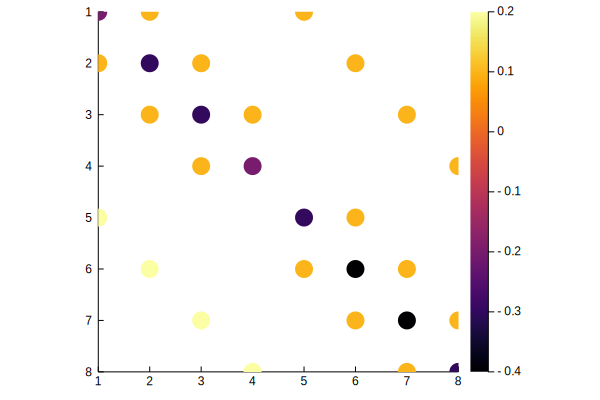

In [42]:
using Plots
spy(L, markersize = 10)

Para calcular uma avaliação dinâmica simples, considere se o retorno do estado $ (i, j) $ é $ r_ {ij} = i + 2j $

In [43]:
r = [i + 2.0j for i in 1:N, j in 1:M]
r = vec(r)  # vetorizá-lo desde qu esteja empilhado na mesma ordem

8-element Array{Float64,1}:
 3.0
 4.0
 5.0
 6.0
 5.0
 6.0
 7.0
 8.0

Resolvendo a equação $ \rho v = r + L v $

In [44]:
ρ = 0.05
v = (ρ * I - L) \ r
reshape(v, N, M)

4×2 Array{Float64,2}:
  87.8992   93.6134
  96.1345  101.849 
 106.723   112.437 
 114.958   120.672 

O `reshape` ajuda a reorganizá-lo novamente para ser bidimensional.

Para encontrar a distribuição estacionária, calculamos o valor próprio e escolhemos o vetor próprio associado a $ \lambda = 0 $. Nesse caso, podemos verificar se é o último.

In [45]:
L_eig = eigen(Matrix(L'))
@assert norm(L_eig.values[end]) < 1E-10

ψ = L_eig.vectors[:,end]
ψ = ψ / sum(ψ)

8-element Array{Float64,1}:
 0.16666666666666677
 0.1666666666666665 
 0.16666666666666682
 0.16666666666666666
 0.08333333333333325
 0.08333333333333345
 0.0833333333333333 
 0.08333333333333334

Remodelando isso para ser bidimensional, se for útil para visualização:

In [46]:
reshape(ψ, N, size(A,1))

4×2 Array{Float64,2}:
 0.166667  0.0833333
 0.166667  0.0833333
 0.166667  0.0833333
 0.166667  0.0833333

### Irredutibulidade

Como nas cadeias discretas de Markov, uma questão-chave é se os CTMCs são redutíveis, ou seja, os estados se comunicam. O problema é isomórfico para determinar se o gráfico direcionado da cadeia de Markov está [fortemente conectado](https://en.wikipedia.org/wiki/Strongly_connected_component).

In [47]:
using LightGraphs
α = 0.1
N = 6
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))

6×6 Tridiagonal{Float64,Array{Float64,1}}:
 -0.1   0.1    ⋅     ⋅     ⋅     ⋅ 
  0.1  -0.2   0.1    ⋅     ⋅     ⋅ 
   ⋅    0.1  -0.2   0.1    ⋅     ⋅ 
   ⋅     ⋅    0.1  -0.2   0.1    ⋅ 
   ⋅     ⋅     ⋅    0.1  -0.2   0.1
   ⋅     ⋅     ⋅     ⋅    0.1  -0.1

Podemos verificar se é possível alternar entre todos os estados em um número finito de etapas com

In [48]:
Q_graph = DiGraph(Q)
@show is_strongly_connected(Q_graph);  # i.e. pode seguir arestas direcionais para chegar a todos os estados

is_strongly_connected(Q_graph) = true


Como alternativa, como um exemplo de uma cadeia Markov redutível em que os estados $ 1 $ e $ 2 $ não podem pular para o estado $ 3 $.

In [49]:
Q = [-0.2 0.2 0
    0.2 -0.2 0
    0.2 0.6 -0.2]
Q_graph = DiGraph(Q)
@show is_strongly_connected(Q_graph);

is_strongly_connected(Q_graph) = false


## Matrizes em Faixas

Uma matriz tridiagonal possui 3 diagonais diferentes de zero. A diagonal principal, a primeira sub-diagonal (isto é, abaixo da diagonal principal) e também a primeira super-diagonal (isto é, acima da diagonal principal).

Este é um caso especial de um tipo mais geral chamado matriz em faixas, em que o número de sub e super-diagonais pode ser maior que 1. A largura total das principais, sub e superdiagonais é chamada de largura de banda. Por exemplo, uma matriz tridiagonal tem uma largura de banda de 3.

Uma matriz em faixas $ N \times N $ com largura de banda $ P $ possui cerca de $ N P $ nonzeros em seu padrão de escassez.

Estes podem ser criados diretamente como uma matriz densa com `diagm`. Por exemplo, com uma largura de banda de três e uma diagonal zero.

In [50]:
diagm(1 => [1,2,3], -1 => [4,5,6])

4×4 Array{Int64,2}:
 0  1  0  0
 4  0  2  0
 0  5  0  3
 0  0  6  0

Ou como uma matriz esparsa,

In [51]:
spdiagm(1 => [1,2,3], -1 => [4,5,6])

4×4 SparseMatrixCSC{Int64,Int64} with 6 stored entries:
  [2, 1]  =  4
  [1, 2]  =  1
  [3, 2]  =  5
  [2, 3]  =  2
  [4, 3]  =  6
  [3, 4]  =  3

Ou, usando diretamente [BandedMatrices.jl](https://github.com/JuliaMatrices/BandedMatrices.jl):

In [52]:
using BandedMatrices
BandedMatrix(1 => [1,2,3], -1 => [4,5,6])

4×4 BandedMatrix{Int64,Array{Int64,2},Base.OneTo{Int64}}:
 0  1  ⋅  ⋅
 4  0  2  ⋅
 ⋅  5  0  3
 ⋅  ⋅  6  0

Há também uma função de conveniência para gerar matrizes aleatórias em faixas:

In [53]:
A = brand(7, 7, 3, 1)  # matriz 7x7, 3 subdiagonais, 1 subdiagonal

7×7 BandedMatrix{Float64,Array{Float64,2},Base.OneTo{Int64}}:
 0.109687  0.719595   ⋅         ⋅         ⋅         ⋅         ⋅      
 0.197615  0.441325  0.486003   ⋅         ⋅         ⋅         ⋅      
 0.909192  0.999804  0.438857  0.424792   ⋅         ⋅         ⋅      
 0.365279  0.231345  0.449552  0.754709  0.155209   ⋅         ⋅      
  ⋅        0.32635   0.374328  0.815217  0.41038   0.13815    ⋅      
  ⋅         ⋅        0.386271  0.770824  0.976365  0.816799  0.841751
  ⋅         ⋅         ⋅        0.624999  0.177116  0.135212  0.158908

E, é claro, algoritmos especializados serão usados para explorar a estrutura ao resolver sistemas lineares. Em particular, a complexidade está relacionada ao $ O (N P_L P_U) $ para larguras de banda superior e inferior $ P $:

In [54]:
@show factorize(Symmetric(A)) |> typeof
A \ rand(7)

factorize(Symmetric(A)) |> typeof = LDLt{Float64,Symmetric{Float64,BandedMatrix{Float64,Array{Float64,2},Base.OneTo{Int64}}}}


7-element Array{Float64,1}:
  -2.8366241417063507
   1.794969986790177 
   1.0559189288823672
   1.261653262303674 
   1.157700843466614 
 -15.915612135771756 
  12.632869787809963 

O algoritmo de fatoração usa uma decomposição LU especializada para matrizes em faixas.


<a id='implementation-numerics'></a>

## Detalhes da Implementação e Performance

Lembre-se da famosa citação de Knuth: “97% das vezes: a otimização prematura é a raiz de todo mal. No entanto, não devemos perder nossas oportunidades nesses 3% críticos ”. O exemplo mais comum de otimização prematura é tentar usar seu próprio modelo mental de compilador enquanto escreve seu código, preocupado com a eficiência do código e (geralmente incorretamente) adivinhar o compilador.

Concretamente, as lições desta seção são:


1. Não se preocupe em otimizar seu código, a menos que você precise. A clareza do código é sua preocupação de primeira ordem.
2. Se você usar os pacotes de outras pessoas, eles poderão se preocupar com o desempenho e você não precisará.
3. Se você precisa absolutamente desses 3% críticos, sua intuição sobre o desempenho geralmente está errada em CPUs e GPUs modernas, portanto, deixe o compilador fazer seu trabalho.
4. Benchmarking (por exemplo, `@ btime`) e [profiling](https://docs.julialang.org/en/v1/manual/profile/) são as ferramentas para descobrir gargalos de desempenho. Se 99% do tempo de computação é gasto em uma função pequena, então não faz sentido otimizar mais nada.
5. Se você fizer um benchmark para mostrar que uma parte específica do código é um problema e não encontrar outra biblioteca que faça um trabalho melhor, poderá se preocupar com o desempenho.


Você raramente chegará ao passo 3, e muito menos ao passo 5.

No entanto, há também um corolário: "não pessimize prematuramente". Ou seja, não faça escolhas que levem a um desempenho ruim sem qualquer troca na clareza de código aprimorada. Por exemplo, escrevendo seus próprios algoritmos quando existe um algoritmo de alto desempenho em um pacote ou na própria Julia, ou preguiçosamente tornando uma matriz densa e descuidando descuidadamente sua estrutura.

### Dificuldade de implementação

Às vezes, a análise numérica se refere ao nível mais baixo de código para operações básicas (por exemplo, um produto escalar, produto matriz-matriz, convoluções) como `kernels`.

Esse tipo de código é difícil de escrever e o desempenho depende das características do hardware subjacente, como o [conjunto de instruções](https://en.wikipedia.org/wiki/Instruction_set_architecture) disponível na CPU específica, o tamanho de o [cache da CPU](https://en.wikipedia.org/wiki/CPU_cache) e o layout das matrizes na memória.

Normalmente, essas operações são gravadas em uma biblioteca intitulada [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms), organizada em diferentes níveis. Os níveis correspondem aproximadamente à ordem computacional das operações: o nível 1 do BLAS é operações de $ O (N) $, como produtos lineares, o nível 2 é operações de $ O (N ^ 2) $, como produtos vetoriais matriciais e o nível 3 são $ O (N ^ 3) $, como produtos matriciais gerais.

Um exemplo de uma biblioteca BLAS é o [OpenBLAS](https://github.com/xianyi/OpenBLAS) usado por padrão em Julia ou o [Intel MKL](https://en.wikipedia.org/wiki/Math_Kernel_Library) usado no Matlab (e Julia se o pacote `MKL.jl` estiver instalado).

No topo do BLAS estão as operações [LAPACK](https://en.wikipedia.org/wiki/LAPACK), que são kernels de nível superior, como fatorações de matriz e algoritmos de autovalor, e geralmente estão nas mesmas bibliotecas (por exemplo, MKL funcionalidade BLAS e LAPACK).

Os detalhes desses pacotes não são especialmente relevantes, mas se você estiver falando sobre desempenho, as pessoas inevitavelmente começarão a discutir esses diferentes pacotes e kernels. Há algumas coisas importantes a serem lembradas:

1. Deixe os kernels de escrita para os especialistas. Mesmo algoritmos de som simples podem ser muito complicados para obter alto desempenho.
2. Sua intuição sobre o desempenho do código provavelmente estará errada. Se você usa bibliotecas de alta qualidade em vez de escrever seus próprios kernels, não precisa usar sua intuição.
3. Não se distraia com o jargão ou as siglas acima se estiver lendo sobre desempenho.  

### Ordenação de linhas e colunas principais

Há um problema de desempenho prático que pode influenciar seu código. Como a memória em uma CPU é linear, as matrizes densas precisam ser armazenadas pelas colunas de empilhamento (chamadas de [ordem principal da coluna](https://en.wikipedia.org/wiki/Row-_and_column-major_order)) ou linhas.

A razão pela qual isso importa é que os compiladores podem gerar melhor desempenho se trabalharem em blocos contíguos de memória, e isso se torna especialmente importante com matrizes grandes devido à interação com o cache da CPU. Escolher a ordem errada quando não houver benefício na clareza do código é um exemplo de pessimização prematura. A diferença de desempenho pode ser de magnitude em alguns casos, e nada em outros.

Uma opção é usar as funções que permitem ao compilador escolher a maneira mais eficiente de atravessar a memória. Se você precisar escolher a ordem de loop você mesmo, poderá experimentar a troca se passa por colunas ou linhas primeiro. Outras vezes, deixe Julia decidir, ou seja, `enumerate` e` eachindex` escolherão a abordagem correta.

Julia, Fortran e Matlab usam a ordem principal da coluna, enquanto C / C ++ e Python usam a ordem principal da linha. Isso significa que, se você encontrar um algoritmo escrito para C / C ++ / Python, às vezes precisará fazer pequenas alterações se o desempenho for um problema.

### Digressão em alocações e operações no local

Embora em geral não tenhamos considerado a otimização do código de desempenho (e focado na escolha de
algoritmos), quando matrizes e vetores se tornam grandes, precisamos ter mais cuidado.

O mais importante a evitar são alocações em excesso, que geralmente ocorrem devido ao uso de
vetores e matrizes temporários quando não são necessários. Às vezes, esses valores temporários extras
pode causar enormes prejuízos no desempenho.

No entanto, recomenda-se cautela, pois alocações em excesso nunca são relevantes para valores escalares e às vezes podem criar código mais rápido para matrizes/vetores menores, pois pode levar a uma melhor [localidade do cache](https://en.wikipedia.org/wiki/Locality_of_reference).

Para ver isso, uma ferramenta conveniente é o benchmarking:

In [55]:
using BenchmarkTools
A = rand(10,10)
B = rand(10,10)
C = similar(A)
function f!(C, A, B)
    D = A*B
    C .= D .+ 1
end
@btime f!($C, $A, $B)

  507.394 ns (1 allocation: 896 bytes)


10×10 Array{Float64,2}:
 2.38445  4.30622  4.15903  3.43694  …  3.82611  3.48099  4.66099  4.35607
 2.07897  3.28677  2.97151  2.58452     2.2157   2.01165  3.32382  2.21331
 2.54002  3.44218  3.4829   2.87813     2.96005  2.66545  3.65305  3.26997
 2.40094  4.18545  3.74416  3.26441     3.51722  3.01934  4.31747  3.32135
 2.55308  4.34568  4.47826  3.4746      3.62313  2.88039  4.73586  3.59672
 3.18104  4.39641  4.05575  3.64642  …  3.61473  3.48923  4.58765  4.03799
 1.83945  2.78571  2.94542  2.3359      2.78569  2.30381  2.96308  2.74603
 3.01062  4.81368  4.80904  4.09877     3.79633  3.59909  5.48354  4.64111
 2.70346  3.68773  4.00306  3.2046      3.50494  2.952    3.97194  3.44871
 3.13711  4.92273  4.50483  3.90205     3.67632  3.14191  5.35983  3.91963

O `!` no `f!` É uma maneira informal de dizer que a função está em mutação e os primeiros argumentos (`C` aqui)
é por convenção os valores modificados.

Na função `f!`, Observe que o `D` é uma variável temporária que é criada e modificada posteriormente. Mas observe que desde
`C` é modificado diretamente, não há necessidade de criar a matriz temporária` D`.

Este é um exemplo de onde uma versão local da multiplicação de matrizes pode ajudar a evitar a alocação.

In [56]:
function f2!(C, A, B)
    mul!(C, A, B)  # multiplicação no lugar
    C .+= 1
end
A = rand(10,10)
B = rand(10,10)
C = similar(A)
@btime f!($C, $A, $B)
@btime f2!($C, $A, $B)

  509.036 ns (1 allocation: 896 bytes)
  439.611 ns (0 allocations: 0 bytes)


10×10 Array{Float64,2}:
 4.17849  3.99982  4.08701  2.9107   …  3.67517  2.94196  2.97447  3.31776
 3.16593  2.78189  2.3274   2.18093     2.99242  1.95574  2.22242  2.46963
 4.22215  4.28371  4.28939  3.7742      4.09352  2.90929  2.49942  4.3231 
 3.31492  3.35675  3.29948  2.42587     3.04878  2.60989  2.24203  2.96472
 3.90282  3.59304  3.44081  3.26894     3.4765   2.74166  2.16695  3.87907
 3.35249  3.38256  3.12494  2.23225  …  3.10104  2.22678  2.49182  2.56156
 5.36237  4.89655  4.94874  4.24799     4.21646  3.44149  3.31918  4.7045 
 3.6767   3.77135  3.41933  3.54367     3.32444  2.95376  2.36089  3.53425
 3.24527  3.1745   2.74173  2.25294     3.57247  2.48904  2.09367  2.76493
 4.59976  4.63393  4.88462  4.04115     3.95369  3.24873  3.08891  4.31279

Observe que, na saída do benchmarking, o `f2!` Não está alocado e está usando a variável `C` pré-alocada diretamente.

Outro exemplo disso são as soluções para equações lineares, nas quais para grandes soluções você pode pré-chamar e reutilizar o
vetor de solução.

In [57]:
A = rand(10,10)
y = rand(10)
z = A \ y  # cria temporário

A = factorize(A)  # local exige fatoração
x = similar(y)  # pré-alocação
ldiv!(x, A, y)  # divisão esquerda no local, usando fatoração

10-element Array{Float64,1}:
  0.43707922462467835
 -0.4255000330850714 
  0.9826038617340918 
 -0.2691960077744889 
  0.48136882810093035
 -0.7545857358302918 
  0.6645076917313447 
  0.22854831057636865
 -1.4456879854514966 
  1.3427409373482915 

No entanto, se você fizer um benchmark com cuidado, verá que isso às vezes é mais lento. Evitar alocações nem sempre é uma boa
idéia - e se preocupar com isso antes do benchmarking é a otimização prematura.

Há uma variedade de outras versões de funções não alocadas. Por exemplo,

In [58]:
A = rand(10,10)
B = similar(A)

transpose!(B, A)  # versão não-alocada de B = transposta(A)

10×10 Array{Float64,2}:
 0.332025   0.234278  0.70827   0.411295   …  0.327127  0.85295    0.11247   
 0.904854   0.827702  0.154587  0.448786      0.178535  0.69811    0.998019  
 0.481155   0.218838  0.584614  0.519837      0.946165  0.143201   0.336193  
 0.993505   0.947485  0.644861  0.0350973     0.351794  0.802639   0.00477567
 0.442824   0.836457  0.308395  0.336602      0.802745  0.0752838  0.0847486 
 0.0680403  0.578927  0.137693  0.411517   …  0.315455  0.0293899  0.617513  
 0.487702   0.115422  0.95813   0.431378      0.877839  0.111185   0.131022  
 0.602005   0.31347   0.276449  0.794457      0.964883  0.474389   0.123424  
 0.812738   0.695384  0.810153  0.135141      0.200575  0.486323   0.992133  
 0.16448    0.745776  0.957567  0.186042      0.639482  0.155409   0.710451  

Por fim, uma fonte comum de alocações desnecessárias é a obtenção de fatias ou partes de matrizes. Por exemplo, o seguinte aloca uma nova matriz `B` e copia os valores.

In [59]:
A = rand(5,5)
B = A[2,:]  # extrair um vetor

5-element Array{Float64,1}:
 0.4267409868807137 
 0.4607555356602602 
 0.9735329756215609 
 0.9120216968454979 
 0.17219390913608557

Para ver essas matrizes diferentes, observe que

In [60]:
A[2,1] = 100.0
@show A[2,1]
@show B[1];

A[2, 1] = 100.0
B[1] = 0.4267409868807137


Em vez de alocar uma nova matriz, você pode fazer uma `view` de uma matriz, que fornece um tipo` AbstractArray` apropriado que não aloca nova memória com a matriz `@ view`.

In [61]:
A = rand(5,5)
B = @view A[2,:]  #  não copia os dados

A[2,1] = 100.0
@show A[2,1]
@show B[1];

A[2, 1] = 100.0
B[1] = 100.0


Mas, novamente, você encontrará muitas vezes que fazer `@ view` leva a um código mais lento. Em vez disso, faça referência e geralmente confie nela para matrizes grandes e para pedaços de memória contíguos (por exemplo, uma coluna em vez de uma linha).

## Exercícios

### Exercício 1

Este exercício é para uma prática de escrever rotinas de baixo nível (ou seja, "kernels") e esperamos convencê-lo a deixar o código de baixo nível para os especialistas.

A fórmula para multiplicação de matrizes é enganosamente simples. Por exemplo, com o produto de matrizes quadradas $ C = A B $ de tamanho $ N \times N $, o elemento $ i, j $ de $ C $ é:

$$
C_{ij} = \sum_{k=1}^N A_{ik} B_{kj}
$$

Como alternativa, você pode pegar uma linha $ A_ {i ,:} $ e a coluna $ B_ {:, j} $ e usar um produto interno:

$$
C_{ij} = A_{i,:} \cdot B_{:,j}
$$

Observe que o produto interno em um espaço discreto é simplesmente uma soma e tem a mesma complexidade da soma (ou seja, operações $ O (N) $).

Para uma matriz densa sem nenhuma estrutura, isso também esclarece por que a complexidade é $ O (N ^ 3) $: é necessário avaliá-la para elementos $ N ^ 2 $ na matriz e fazer $ O (N) $ operação cada vez.

Para este exercício, implemente a multiplicação de matrizes e compare o desempenho em algumas permutações.

1. Use a função interna em Julia (ou seja, `` C = A * B`` ou, para uma melhor comparação, a versão local `mul! (C, A, B)` que funciona com dados pré-alocados)
2. Faça um loop sobre cada $ C_ {ij} $ pela linha primeiro (ou seja, o índice `i`) e use um loop` for` para o produto interno
3. Faça um loop sobre cada $ C_ {ij} $ pela coluna primeiro (ou seja, o índice `j`) e use um loop` for` para o produto interno
4. Faça o mesmo, mas use o produto `dot 'em vez da soma.
5. Escolha sua melhor implementação e, em seguida, para matrizes de alguns tamanhos diferentes `N = 10`,` N = 1000`, etc. e compare a taxa de desempenho de sua melhor implementação com a biblioteca BLAS incorporada.


Mais algumas dicas:

- Você pode usar apenas matrizes aleatórias, por exemplo `A = margem (N, N)`, etc.
- Para todos eles, pré-aloque previamente a matriz $ C $ com `C = similar (A)` ou algo equivalente.
- Para comparar o desempenho, coloque seu código em uma função e use a macro `@ btime` para cronometrar.  

### Exercício 2a

Aqui calcularemos a evolução do pdf de uma cadeia de Markov de tempo discreto, $ \ psi_t $, dada a condição inicial $ \psi_0 $.

Comece com uma matriz tridiagonal simétrica simples

In [62]:
N = 100
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2)])
A_adjoint = A';

1. Escolha um `T` grande e use a condição inicial $ \psi_0 = \begin {bmatrix} 1 & 0 & \ldots & 0 \end {bmatrix} $
2. Escreva o código para calcular $ \ psi_t $ para alguns $ T $ iterando o mapa para cada $ t $, ou seja,


$$
\psi_ {t + 1} = A '\psi_t
$$

3. Qual é a ordem computacional desse cálculo $ \psi_T $ usando essa abordagem de iteração $ T <N $?
4. Qual é a ordem computacional de $ (A ') ^ T = (A \ldots A) $ e então $ \psi_T = (A') ^ T \psi_0 $ para $ T <N $?
5. Benchmark calculando $ \psi_T $ com o cálculo iterativo acima, bem como o $ \psi_T = (A ') ^ T \psi_0 $ direto para ver qual é mais rápido. Você pode obter a potência da matriz com apenas `A_adjoint ^ T`, que usa algoritmos especializados mais rapidamente e com mais precisão do que a multiplicação de matriz repetida (mas com a mesma ordem computacional).
6. Verifique o mesmo se $ T = 2 N $


* Nota: * O algoritmo usado em Julia para obter poderes da matriz depende da estrutura da matriz, como sempre. No caso simétrico, ele pode usar uma composição independente, enquanto que com uma matriz densa geral ele usa [quadrado e escala](https://doi.org/10.1137/090768539).

### Exercício 2b

Com a mesma configuração do Exercício 2a, faça uma [autodecomposição](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) de `A_transposta`. Ou seja, use `eigen` para fatorar o adjacente $ A '= Q \Lambda Q ^ {- 1} $ onde $ Q $ a matriz de vetores próprios e $ \Lambda $ a matriz diagonal de valores próprios. Calcule $ Q ^ {- 1} $ a partir dos resultados.

Use a matriz fatorada para calcular a sequência de $ \ psi_t = (A ') ^ t \ psi_0 $ usando o relacionamento

$$
\psi_t = Q \Lambda ^ t Q ^ {- 1} \psi_0
$$

Onde os poderes matriciais das matrizes diagonais são simplesmente os poderes dos elementos de cada elemento.

Compare a velocidade do cálculo da sequência de $ \psi_t $ até `T = 2N` usando este método. Em princípio, a fatoração e o cálculo fácil da potência devem oferecer benefícios em comparação com a simples iteração do mapa, como fizemos no Exercício 2a. Explique por que ele usa ou não a ordem computacional de cada abordagem.